# NLP: Analysis of Headlines

### Topic modeling, frequent term analysis, sentiment analysis.

The goal of this notebook is to do an NLP analysis on the police data, such as analysis of the newspaper headlines, as well as the overall EDA.

#### Importing tools and libraries

In [205]:
import pandas as pd
from collections import defaultdict 
import re, string 

from gensim import corpora
from gensim.models import LdaModel 
import pyLDAvis.gensim
import nltk
from nltk.corpus import stopwords

import spacy
import en_core_web_sm
spacy_parser = spacy.load('en_core_web_sm')

In [4]:
df = pd.read_csv('cops_cleaned (2).csv')

In [171]:
df.sample(5)

,court,status,display_publicly,first_name,middle_name,last_name,suffix,news_links,news_headlines,crime_date,...,end_date,rank_orig,rank,conviction1,conviction2,conviction3,conviction4,other_conviction,cii_number,case_number
240,Lake,Clip Case,True,David,NaN,Krastof,NaN,https://www.eastbaytimes.com/2015/05/26/san-pa...,[San Pablo police commander arrested on suspic...,NaT,...,1/26/2016,CMDR,Commander,NaN,NaN,NaN,NaN,NaN,1.008560e+09,NaN
562,NaN,y,True,Craig,Michael,Records,NaN,https://www.mercurynews.com/2019/04/16/alameda...,[Alameda County District Attorney releases rec...,2007-06-03,...,6/10/2009,DPTY,Deputy,Felony: PC 243(D) - BATTERY WITH SERIOUS BODIL...,NaN,NaN,NaN,NaN,1.021270e+09,H47557
626,San Diego,2013 clips,True,Jeffrey,NaN,Blackford,NaN,https://www.nbcsandiego.com/news/local/San-Die...,[No Jail Time for SDPD Detective in DUI Crash]...,NaT,...,NaN,PO,Police Officer,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,NaN,Clip Case,True,Christopher,Mark,Heath,NaN,https://www.justice.gov/usao-mdpa/pr/former-ca...,[Former California Deputy Sheriff Sentenced To...,NaT,...,1/15/2016,DPTY,Deputy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,NaN,y,True,John,Leighton,Mitchell,NaN,NaN,NaN,2016-01-16,...,1/25/2013,RIII,Reserve Level 3,Misdemeanor: VC 23152(B) - DUI ALCOHOL/0.08 PE...,Misdemeanor: PC 25850(A) PC-CARRY LOADED F/ARM...,NaN,NaN,NaN,1.003358e+09,16MI005280


In [17]:
df.columns

Index(['court', 'status', 'display_publicly', 'first_name', 'middle_name',
       'last_name', 'suffix', 'news_links', 'news_headlines', 'crime_date',
       'filing_date', 'sentencing_date', 'charge1', 'charge1_desc', 'charge2',
       'charge2_desc', 'charge3', 'charge3_desc', 'charge4', 'charge4_desc',
       'charge5', 'charge5_desc', 'other_charges', 'currently_employed',
       'county', 'department_orig', 'department', 'start_date', 'end_date',
       'rank_orig', 'rank', 'conviction1', 'conviction2', 'conviction3',
       'conviction4', 'other_conviction', 'cii_number', 'case_number'],
      dtype='object')

**Data Dictionary:**

**ID:** a unique identifier for each row used to connect to the IDs in News Links / scraped articles in different spreadsheets; this was added to the spreadsheet by AA for network analysis

**Label:** First name; this was added to the spreadsheet by AA for network analysis

Timeset (empty); this was added to the spreadsheet by AA for network analysis

**Court:** county or city courthouse

**Status:** Notes taken by the journalists who ‘cleaned’ the data. ‘Y’ meant they corroborated the case with the police department or a court case, and ‘cli case’ meant they found a news article mentioning the cop. The journalists used great caution before publishing a name of someone who may not have been a cop or mistaking their identity for a civilian. So each name was corroborated before publication in the database.

**Display_publicly:** boolean (T/F) whether this data should be public or private

**First_name:** first name

**Middle_name:** middle name

**Last_name:** last name

**Suffix:** if the person has a suffix

**News_links**: link to news article(s) associated with the crime(s)

**News_headlines:** headline of the news article(s)

**Crime_date:** date of the crime

**Filing_date:** date in which the DoJ filed the charges

**Sentencing_date:** date in which the DoJ filed the sentence

**Charge1:** first formal charge

**Charge1_desc:** description of the first charge

**Charge2:** second formal charge

**Charge2_desc:** description of the second charge

**Charge3:** if there was a third charge

**Charge3_desc:** description of the third charge

**Charge4:** if there was a fourth charge

**Charge4_desc:** description of the fourth charge

**Charge5:** if there was a fifth charge

**Charge5_desc:** description of the fifth charge

**Other_charges:** additional charges listed

**Currently_employed:** whether the officer is currently employed in the same department

**County:** county in which the police officer was employed

**Department_orig:** the original police department in which the officer was employed

**Department:** the current department in which the officer is employed

**Start_date:** when the police officer began their employment

**End_date:** when the police officer was terminated

**Rank_orig:** rank of the officer when the committed the crime

**Rank:** current rank of the officer

**Conviction1:** first conviction passed in a court of law

**Conviction2:** second conviction passed in a court of law

**Conviction3:** third conviction passed in a court of law

**Conviction4:** fourth conviction passed in a court of law

**Other_conviction:** additional convictions passed in a court of law

**Cii_number:** the ID for the criminal / officer when charged used by the DoJ

**Case_number:** the ID of the case

In [22]:
df['crime_date'].dtypes

dtype('O')

Converting the data into the datetime format, so that it can be sorted chronologically.

In [25]:
pd.to_datetime(df['crime_date'])

0     2010-01-21
1     2010-06-10
2     2014-11-01
3     2010-01-01
4     2013-10-15
         ...    
644          NaT
645   2012-12-04
646   2013-04-26
647   2011-11-04
648   2011-03-02
Name: crime_date, Length: 649, dtype: datetime64[ns]

In [26]:
df['crime_date'].dtypes

dtype('<M8[ns]')

####  Analyzing the news headlines: dataframe creation

Let's see what the newspapers are saying about those violations.

Out of 649 incidents, 177 are missing the headlines.

In [35]:
df['news_headlines'].isnull().sum()

177

In [37]:
df.shape

(649, 38)

For the sake of this particular chapter of our analysis, I will only keep the rows that had valid headlines.

In [38]:
df_headlines = df[df['news_headlines'].notna()] 

In [39]:
df_headlines

,court,status,display_publicly,first_name,middle_name,last_name,suffix,news_links,news_headlines,crime_date,...,end_date,rank_orig,rank,conviction1,conviction2,conviction3,conviction4,other_conviction,cii_number,case_number
1,NaN,y,True,Mario,Alonso,Mottu,Sr.,https://www.thecalifornian.com/story/news/crim...,"[Ex-King City cop gets 30 days' jail, probatio...",2010-06-10,...,3/20/2015,PO,Police Officer,Felony: 504 PC-EMBEZZLE PROPERTY BY PUBLIC/PRI...,Misdemeanor: 504 PC-EMBEZZLE PROPERTY BY PUBLI...,NaN,NaN,NaN,1.012285e+09,ss140444b
7,San Diego,Clip Case,True,Timothy,NaN,Wilson,Jr.,https://www.nbcsandiego.com/news/local/Convict...,[Convicted Sheriff's Deputy Suspected in Two O...,NaT,...,10/9/2018,JDEP,Jail Deputy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,y,True,Patrick,Francis,Cooney,Jr.,https://www.kcra.com/article/new-details-emerg...,[New details arise in CHP officer's child porn...,2016-06-16,...,1/30/2017,PO,Police Officer,Felony: 311.11(A) PC-POSS/ETC OBS MTR:MNR:SEX,NaN,NaN,NaN,NaN,1.011526e+09,62-148459
10,Merced,Clip Case,True,Dennis,James,Frank,Jr.,https://www.mercedsunstar.com/news/local/crime...,[Ex-Atwater police officer sentenced to jail a...,NaT,...,11/18/2016,PO,Police Officer,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,y,True,Walter,NaN,Gutierrez,Jr.,https://patch.com/california/palmdesert/former...,[Former Blythe Policeman Sentenced in Perjury ...,2014-01-21,...,12/3/2015,SGT,Sergeant,Misdemeanor: PC 118.1 PEACE OFFICER FILES FALS...,NaN,NaN,NaN,NaN,1.011800e+09,BLF1400282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,NaN,y,True,Doug,Alan,Swanson,NaN,https://www.bakersfield.com/news/deputy-arrest...,[Deputy arrested on suspicion of spousal abuse...,2012-06-30,...,NaN,RI,Reserve Level 1,Misdemeanor: PC415(2)-DISTURBS BY LOUD/UNREASO...,NaN,NaN,NaN,NaN,1.027114e+09,BM807433A
640,Tulare,Clip Case,True,Michael,Anthony,Watson,NaN,https://www.fresnobee.com/news/local/crime/art...,[Tulare County sheriff's captain arrested on s...,NaT,...,NaN,CAPT,Captain,NaN,NaN,NaN,NaN,NaN,1.008712e+09,NaN
642,NaN,y,True,Richard,NaN,Garcia,NaN,https://www.latimes.com/local/lanow/la-me-ln-l...,[LAPD officer is spared time behind bars in So...,NaT,...,NaN,NaN,NaN,Misdemeanor: 149 PC-ASSAULT BY PUBLIC OFFICER,NaN,NaN,NaN,NaN,1.026110e+09,BA435794
643,Fresno,2010 clip,True,Ron,NaN,Hughes,NaN,https://www.fresnobee.com/news/local/community...,[Fresno police sergeant guilty of off-duty DUI...,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data pre-processing

Before writing a pre-processing function, some regex research is needed:

Swap with an empty space everything that is not a word or a number:

In [180]:
headlines = [re.sub(r'[^\w\s]',' ',str(item)) for item in df_headlines.news_headlines]

Matches anything attached to a digit and removes it:

In [181]:
headlines = [re.sub(r'\d+','', str(item)) for item in df_headlines.news_headlines]

This regex pattern will remove urls: everything in-between the parentheses including the parentheses themselves:

In [183]:
headlines = [re.sub(r'\(.*?\)', '',str(item)) for item in df_headlines.news_headlines]

This pattern will remove punctuation:

In [155]:
headlines = [re.sub('[%s]' % re.escape(string.punctuation), '',str(item)) for item in headlines]

#### Pre-processing function

Putting it all together in to a function:

In [189]:
def preprocess(text):
    
    text = [re.sub(r'\(.*?\)', ' ',str(item)) for item in text]
    text = [re.sub(r'[^\w\s]','',str(item)) for item in text]
    text = [re.sub(r'\d+','', str(item)) for item in text]
    text = [re.sub('[%s]' % re.escape(string.punctuation), '',str(item)) for item in text]
    text = [re.sub('[‘’“”…]', '',str(item)) for item in text]
    text = [re.sub('\n', ' ', str(item)) for item in text]
    text = [re.sub(' +', ' ',str(item)) for item in text]
    
    return text

In [200]:
df_headlines['clean_headlines'] = preprocess(df_headlines.news_headlines)

/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [202]:
df_headlines['clean_headlines'] = df_headlines['clean_headlines'].str.lower()

/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [203]:
df_headlines

,court,status,display_publicly,first_name,middle_name,last_name,suffix,news_links,news_headlines,crime_date,...,rank_orig,rank,conviction1,conviction2,conviction3,conviction4,other_conviction,cii_number,case_number,clean_headlines
1,NaN,y,True,Mario,Alonso,Mottu,Sr.,https://www.thecalifornian.com/story/news/crim...,"[Ex-King City cop gets 30 days' jail, probatio...",2010-06-10,...,PO,Police Officer,Felony: 504 PC-EMBEZZLE PROPERTY BY PUBLIC/PRI...,Misdemeanor: 504 PC-EMBEZZLE PROPERTY BY PUBLI...,NaN,NaN,NaN,1.012285e+09,ss140444b,exking city cop gets days jail probation
7,San Diego,Clip Case,True,Timothy,NaN,Wilson,Jr.,https://www.nbcsandiego.com/news/local/Convict...,[Convicted Sheriff's Deputy Suspected in Two O...,NaT,...,JDEP,Jail Deputy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,convicted sheriffs deputy suspected in two oth...
9,NaN,y,True,Patrick,Francis,Cooney,Jr.,https://www.kcra.com/article/new-details-emerg...,[New details arise in CHP officer's child porn...,2016-06-16,...,PO,Police Officer,Felony: 311.11(A) PC-POSS/ETC OBS MTR:MNR:SEX,NaN,NaN,NaN,NaN,1.011526e+09,62-148459,new details arise in chp officers child porn a...
10,Merced,Clip Case,True,Dennis,James,Frank,Jr.,https://www.mercedsunstar.com/news/local/crime...,[Ex-Atwater police officer sentenced to jail a...,NaT,...,PO,Police Officer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exatwater police officer sentenced to jail aft...
11,NaN,y,True,Walter,NaN,Gutierrez,Jr.,https://patch.com/california/palmdesert/former...,[Former Blythe Policeman Sentenced in Perjury ...,2014-01-21,...,SGT,Sergeant,Misdemeanor: PC 118.1 PEACE OFFICER FILES FALS...,NaN,NaN,NaN,NaN,1.011800e+09,BLF1400282,former blythe policeman sentenced in perjury c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,NaN,y,True,Doug,Alan,Swanson,NaN,https://www.bakersfield.com/news/deputy-arrest...,[Deputy arrested on suspicion of spousal abuse...,2012-06-30,...,RI,Reserve Level 1,Misdemeanor: PC415(2)-DISTURBS BY LOUD/UNREASO...,NaN,NaN,NaN,NaN,1.027114e+09,BM807433A,deputy arrested on suspicion of spousal abuse
640,Tulare,Clip Case,True,Michael,Anthony,Watson,NaN,https://www.fresnobee.com/news/local/crime/art...,[Tulare County sheriff's captain arrested on s...,NaT,...,CAPT,Captain,NaN,NaN,NaN,NaN,NaN,1.008712e+09,NaN,tulare county sheriffs captain arrested on sus...
642,NaN,y,True,Richard,NaN,Garcia,NaN,https://www.latimes.com/local/lanow/la-me-ln-l...,[LAPD officer is spared time behind bars in So...,NaT,...,NaN,NaN,Misdemeanor: 149 PC-ASSAULT BY PUBLIC OFFICER,NaN,NaN,NaN,NaN,1.026110e+09,BA435794,lapd officer is spared time behind bars in sou...
643,Fresno,2010 clip,True,Ron,NaN,Hughes,NaN,https://www.fresnobee.com/news/local/community...,[Fresno police sergeant guilty of off-duty DUI...,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fresno police sergeant guilty of offduty dui


#### Lemmatization

In [209]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df_headlines['headlines_lemmatized'] = df_headlines.clean_headlines.apply(lemmatize_text)

/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [210]:
df_headlines

,court,status,display_publicly,first_name,middle_name,last_name,suffix,news_links,news_headlines,crime_date,...,rank,conviction1,conviction2,conviction3,conviction4,other_conviction,cii_number,case_number,clean_headlines,headlines_lemmatized
1,NaN,y,True,Mario,Alonso,Mottu,Sr.,https://www.thecalifornian.com/story/news/crim...,"[Ex-King City cop gets 30 days' jail, probatio...",2010-06-10,...,Police Officer,Felony: 504 PC-EMBEZZLE PROPERTY BY PUBLIC/PRI...,Misdemeanor: 504 PC-EMBEZZLE PROPERTY BY PUBLI...,NaN,NaN,NaN,1.012285e+09,ss140444b,exking city cop gets days jail probation,"[exking, city, cop, get, day, jail, probation]"
7,San Diego,Clip Case,True,Timothy,NaN,Wilson,Jr.,https://www.nbcsandiego.com/news/local/Convict...,[Convicted Sheriff's Deputy Suspected in Two O...,NaT,...,Jail Deputy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,convicted sheriffs deputy suspected in two oth...,"[convicted, sheriff, deputy, suspected, in, tw..."
9,NaN,y,True,Patrick,Francis,Cooney,Jr.,https://www.kcra.com/article/new-details-emerg...,[New details arise in CHP officer's child porn...,2016-06-16,...,Police Officer,Felony: 311.11(A) PC-POSS/ETC OBS MTR:MNR:SEX,NaN,NaN,NaN,NaN,1.011526e+09,62-148459,new details arise in chp officers child porn a...,"[new, detail, arise, in, chp, officer, child, ..."
10,Merced,Clip Case,True,Dennis,James,Frank,Jr.,https://www.mercedsunstar.com/news/local/crime...,[Ex-Atwater police officer sentenced to jail a...,NaT,...,Police Officer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exatwater police officer sentenced to jail aft...,"[exatwater, police, officer, sentenced, to, ja..."
11,NaN,y,True,Walter,NaN,Gutierrez,Jr.,https://patch.com/california/palmdesert/former...,[Former Blythe Policeman Sentenced in Perjury ...,2014-01-21,...,Sergeant,Misdemeanor: PC 118.1 PEACE OFFICER FILES FALS...,NaN,NaN,NaN,NaN,1.011800e+09,BLF1400282,former blythe policeman sentenced in perjury c...,"[former, blythe, policeman, sentenced, in, per..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,NaN,y,True,Doug,Alan,Swanson,NaN,https://www.bakersfield.com/news/deputy-arrest...,[Deputy arrested on suspicion of spousal abuse...,2012-06-30,...,Reserve Level 1,Misdemeanor: PC415(2)-DISTURBS BY LOUD/UNREASO...,NaN,NaN,NaN,NaN,1.027114e+09,BM807433A,deputy arrested on suspicion of spousal abuse,"[deputy, arrested, on, suspicion, of, spousal,..."
640,Tulare,Clip Case,True,Michael,Anthony,Watson,NaN,https://www.fresnobee.com/news/local/crime/art...,[Tulare County sheriff's captain arrested on s...,NaT,...,Captain,NaN,NaN,NaN,NaN,NaN,1.008712e+09,NaN,tulare county sheriffs captain arrested on sus...,"[tulare, county, sheriff, captain, arrested, o..."
642,NaN,y,True,Richard,NaN,Garcia,NaN,https://www.latimes.com/local/lanow/la-me-ln-l...,[LAPD officer is spared time behind bars in So...,NaT,...,NaN,Misdemeanor: 149 PC-ASSAULT BY PUBLIC OFFICER,NaN,NaN,NaN,NaN,1.026110e+09,BA435794,lapd officer is spared time behind bars in sou...,"[lapd, officer, is, spared, time, behind, bar,..."
643,Fresno,2010 clip,True,Ron,NaN,Hughes,NaN,https://www.fresnobee.com/news/local/community...,[Fresno police sergeant guilty of off-duty DUI...,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fresno police sergeant guilty of offduty dui,"[fresno, police, sergeant, guilty, of, offduty..."


#### Stop-word removal

In [211]:
my_stopwords = set(stopwords.words('english'))
df_headlines['headlines_fin'] = df_headlines['headlines_lemmatized'].apply(lambda text_list: [x for x in text_list if x not in stopwords.words('english')])

/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
df_headlines

,court,status,display_publicly,first_name,middle_name,last_name,suffix,news_links,news_headlines,crime_date,...,conviction1,conviction2,conviction3,conviction4,other_conviction,cii_number,case_number,clean_headlines,headlines_lemmatized,headlines_fin
1,NaN,y,True,Mario,Alonso,Mottu,Sr.,https://www.thecalifornian.com/story/news/crim...,"[Ex-King City cop gets 30 days' jail, probatio...",2010-06-10,...,Felony: 504 PC-EMBEZZLE PROPERTY BY PUBLIC/PRI...,Misdemeanor: 504 PC-EMBEZZLE PROPERTY BY PUBLI...,NaN,NaN,NaN,1.012285e+09,ss140444b,exking city cop gets days jail probation,"[exking, city, cop, get, day, jail, probation]","[exking, city, cop, get, day, jail, probation]"
7,San Diego,Clip Case,True,Timothy,NaN,Wilson,Jr.,https://www.nbcsandiego.com/news/local/Convict...,[Convicted Sheriff's Deputy Suspected in Two O...,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,convicted sheriffs deputy suspected in two oth...,"[convicted, sheriff, deputy, suspected, in, tw...","[convicted, sheriff, deputy, suspected, two, s..."
9,NaN,y,True,Patrick,Francis,Cooney,Jr.,https://www.kcra.com/article/new-details-emerg...,[New details arise in CHP officer's child porn...,2016-06-16,...,Felony: 311.11(A) PC-POSS/ETC OBS MTR:MNR:SEX,NaN,NaN,NaN,NaN,1.011526e+09,62-148459,new details arise in chp officers child porn a...,"[new, detail, arise, in, chp, officer, child, ...","[new, detail, arise, chp, officer, child, porn..."
10,Merced,Clip Case,True,Dennis,James,Frank,Jr.,https://www.mercedsunstar.com/news/local/crime...,[Ex-Atwater police officer sentenced to jail a...,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exatwater police officer sentenced to jail aft...,"[exatwater, police, officer, sentenced, to, ja...","[exatwater, police, officer, sentenced, jail, ..."
11,NaN,y,True,Walter,NaN,Gutierrez,Jr.,https://patch.com/california/palmdesert/former...,[Former Blythe Policeman Sentenced in Perjury ...,2014-01-21,...,Misdemeanor: PC 118.1 PEACE OFFICER FILES FALS...,NaN,NaN,NaN,NaN,1.011800e+09,BLF1400282,former blythe policeman sentenced in perjury c...,"[former, blythe, policeman, sentenced, in, per...","[former, blythe, policeman, sentenced, perjury..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,NaN,y,True,Doug,Alan,Swanson,NaN,https://www.bakersfield.com/news/deputy-arrest...,[Deputy arrested on suspicion of spousal abuse...,2012-06-30,...,Misdemeanor: PC415(2)-DISTURBS BY LOUD/UNREASO...,NaN,NaN,NaN,NaN,1.027114e+09,BM807433A,deputy arrested on suspicion of spousal abuse,"[deputy, arrested, on, suspicion, of, spousal,...","[deputy, arrested, suspicion, spousal, abuse]"
640,Tulare,Clip Case,True,Michael,Anthony,Watson,NaN,https://www.fresnobee.com/news/local/crime/art...,[Tulare County sheriff's captain arrested on s...,NaT,...,NaN,NaN,NaN,NaN,NaN,1.008712e+09,NaN,tulare county sheriffs captain arrested on sus...,"[tulare, county, sheriff, captain, arrested, o...","[tulare, county, sheriff, captain, arrested, s..."
642,NaN,y,True,Richard,NaN,Garcia,NaN,https://www.latimes.com/local/lanow/la-me-ln-l...,[LAPD officer is spared time behind bars in So...,NaT,...,Misdemeanor: 149 PC-ASSAULT BY PUBLIC OFFICER,NaN,NaN,NaN,NaN,1.026110e+09,BA435794,lapd officer is spared time behind bars in sou...,"[lapd, officer, is, spared, time, behind, bar,...","[lapd, officer, spared, time, behind, bar, sou..."
643,Fresno,2010 clip,True,Ron,NaN,Hughes,NaN,https://www.fresnobee.com/news/local/community...,[Fresno police sergeant guilty of off-duty DUI...,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fresno police sergeant guilty of offduty dui,"[fresno, police, sergeant, guilty, of, offduty...","[fresno, police, sergeant, guilty, offduty, duo]"


#### LDA and Topic Modeling

We will create the corpus out of the prepared headline texts (headlines_fin), and use the Latent Dirichlet Allocation for topic modeling.

In [234]:
fin_heads = df_headlines['headlines_fin']

In [236]:
texts = [[word for word in document] for document in fin_heads]

Removing less frequent words for more efficient topic modeling.

In [238]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
         frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

Creating mappings between words and their integer ids.

In [239]:
dictionary = corpora.Dictionary(texts)

Converting tokenized documents to vectors.

In [240]:
corpus = [dictionary.doc2bow(text) for text in texts]

Modeling: number of topics chosen arbitrarily.

In [241]:
NUM_TOPICS = 6  
ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=12)

In [242]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.068*"sentenced" + 0.052*"former" + 0.052*"officer" + 0.043*"prison" + 0.037*"police" + 0.029*"deputy" + 0.022*"case" + 0.021*"sheriff" + 0.020*"year" + 0.019*"county"')
(1, '0.059*"deputy" + 0.042*"gun" + 0.035*"cop" + 0.031*"guilty" + 0.031*"sheriff" + 0.029*"pleads" + 0.025*"former" + 0.018*"outside" + 0.016*"firing" + 0.015*"offduty"')
(2, '0.074*"officer" + 0.040*"sex" + 0.038*"chp" + 0.035*"get" + 0.025*"charge" + 0.023*"plea" + 0.022*"case" + 0.021*"deputy" + 0.021*"jail" + 0.020*"probation"')
(3, '0.073*"officer" + 0.061*"police" + 0.044*"former" + 0.043*"pleads" + 0.033*"sentenced" + 0.028*"cop" + 0.025*"contest" + 0.025*"guilty" + 0.021*"get" + 0.019*"lapd"')
(4, '0.094*"deputy" + 0.064*"county" + 0.060*"sheriff" + 0.036*"former" + 0.027*"jail" + 0.025*"santa" + 0.022*"clara" + 0.020*"cop" + 0.019*"sentenced" + 0.017*"convicted"')
(5, '0.043*"police" + 0.040*"officer" + 0.040*"arrested" + 0.035*"former" + 0.033*"sheriff" + 0.033*"deputy" + 0.026*"domestic" + 0.026*"viol

In [243]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,sentenced,deputy,officer,officer,deputy,police
1,former,gun,sex,police,county,officer
2,officer,cop,chp,former,sheriff,arrested
3,prison,guilty,get,pleads,former,former
4,police,sheriff,charge,sentenced,jail,sheriff
5,deputy,pleads,plea,cop,santa,deputy
6,case,former,case,contest,clara,domestic
7,sheriff,outside,deputy,guilty,cop,violence
8,year,firing,jail,get,sentenced,charge
9,county,offduty,probation,lapd,convicted,duo


##### Topics discovered:

1. Drugs
2. Fraud
3. Sexual assualt
4. Domestic violence etc.

#### Frequent term analysis

In [276]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = STOPWORDS
#stopwords.add('will')

In [263]:
df_headlines['headlines_joined'] = df_headlines.headlines_fin.apply(', '.join)
df_headlines['headlines_joined'] = df_headlines['headlines_joined'].astype(str)

/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [266]:
media_headlines = df_headlines['headlines_joined']

In [277]:
wordcloud = WordCloud(stopwords=stopwords, background_color="black", max_words=100, width = 480, height = 480).generate(' '.join(media_headlines))

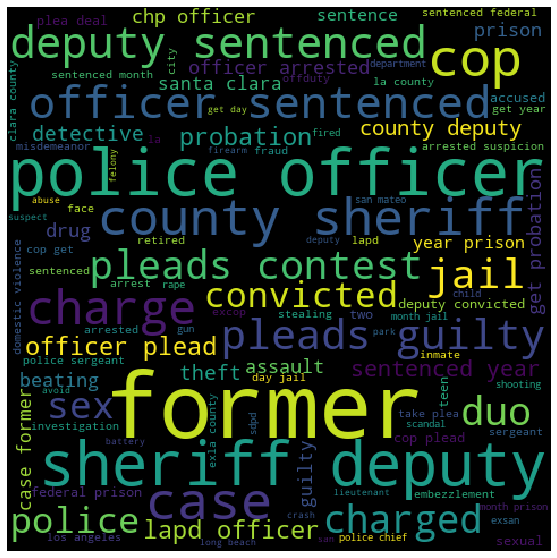

In [279]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off");

### Sentiment Analysis

In [280]:
import nltk 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sasha_prokhorova/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [282]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in media_headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headlines_fin'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'headlines_fin': 'exking, city, cop, get, day, jail, probation'}, {'neg': 0.147, 'neu': 0.853, 'pos': 0.0, 'compound': -0.2263, 'headlines_fin': 'convicted, sheriff, deputy, suspected, two, sexual, battery, case, newly, released, record, show'}, {'neg': 0.297, 'neu': 0.703, 'pos': 0.0, 'compound': -0.6705, 'headlines_fin': 'new, detail, arise, chp, officer, child, porn, arrest, veteran, chp, officer, arrested, child, pornography, case'}]


In [283]:
sentiment_df = pd.DataFrame.from_records(results)
sentiment_df.sample(20)

,neg,neu,pos,compound,headlines_fin
119,0.375,0.625,0.000,-0.5859,"exhb, detective, sentenced, probation, communi..."
161,0.552,0.448,0.000,-0.7506,"exla, county, sheriff, deputy, sentenced, pris..."
31,0.688,0.312,0.000,-0.7650,"deputy, pleads, guilty, pill, fraud"
7,0.177,0.823,0.000,-0.4215,"former, beaumont, police, chief, frank, coe, f..."
118,0.254,0.593,0.153,-0.2960,"los, angeles, deputy, break, rank, admit, beat..."
355,0.432,0.568,0.000,-0.5859,"former, deputy, get, year, assault, exgirlfriend"
252,0.271,0.729,0.000,-0.3818,"lapd, officer, lied, oath, drug, probe, jury, ..."
213,0.275,0.725,0.000,-0.2263,"chief, suspected, duo, driver, rpd, officer"
442,0.000,1.000,0.000,0.0000,"exsan, leandro, cop, convicted, gropings, exof..."
22,0.155,0.845,0.000,-0.2960,"riverside, police, officer, suspect, robbery, ..."


Converting the sentencing date into the datetime format, so that it can be plotted.

In [284]:
df_headlines['sentencing_date'] = pd.to_datetime(df_headlines['sentencing_date'])

/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [287]:
df_headlines[['headlines_fin', 'sentencing_date']].head()

,headlines_fin,sentencing_date
1,"[exking, city, cop, get, day, jail, probation]",2015-10-07
7,"[convicted, sheriff, deputy, suspected, two, s...",NaT
9,"[new, detail, arise, chp, officer, child, porn...",2017-04-19
10,"[exatwater, police, officer, sentenced, jail, ...",NaT
11,"[former, blythe, policeman, sentenced, perjury...",2015-10-07


In [289]:
sentence_date = df_headlines['sentencing_date']

In [290]:
sentiment_df = pd.merge(sentiment_df, sentence_date, left_index=True, right_index=True)

In [291]:
sentiment_df

,neg,neu,pos,compound,headlines_fin,sentencing_date
1,0.147,0.853,0.0,-0.2263,"convicted, sheriff, deputy, suspected, two, se...",2015-10-07
7,0.177,0.823,0.0,-0.4215,"former, beaumont, police, chief, frank, coe, f...",NaT
9,0.000,1.000,0.0,0.0000,"former, cop, get, jail, probation, ticket, fixing",2017-04-19
10,0.304,0.696,0.0,-0.5423,"former, police, officer, receives, felony, pro...",NaT
11,0.280,0.720,0.0,-0.5423,"former, rialto, police, officer, take, plea, d...",2015-10-07
...,...,...,...,...,...,...
463,0.351,0.649,0.0,-0.4019,"jail, time, sdpd, detective, duo, crash",NaT
464,0.496,0.504,0.0,-0.7845,"san, jose, police, officer, arrested, time, sh...",2011-08-16
465,0.231,0.769,0.0,-0.2023,"sheriff, deputy, charged, duo, allegedly, spee...",2013-02-06
466,0.429,0.571,0.0,-0.6705,"judge, jail, time, deputy, killed, two, cyclist",2014-03-21


In [292]:
sentiment_df['label'] = 0
sentiment_df.loc[sentiment_df['compound'] > 0.2, 'label'] = 1
sentiment_df.loc[sentiment_df['compound'] < -0.2, 'label'] = -1
sentiment_df.head()

,neg,neu,pos,compound,headlines_fin,sentencing_date,label
1,0.147,0.853,0.0,-0.2263,"convicted, sheriff, deputy, suspected, two, se...",2015-10-07,-1
7,0.177,0.823,0.0,-0.4215,"former, beaumont, police, chief, frank, coe, f...",NaT,-1
9,0.000,1.000,0.0,0.0000,"former, cop, get, jail, probation, ticket, fixing",2017-04-19,0
10,0.304,0.696,0.0,-0.5423,"former, police, officer, receives, felony, pro...",NaT,-1
11,0.280,0.720,0.0,-0.5423,"former, rialto, police, officer, take, plea, d...",2015-10-07,-1


In [293]:
sentiment_df.label.value_counts(normalize=True) * 100

-1    73.142857
 0    25.428571
 1     1.428571
Name: label, dtype: float64

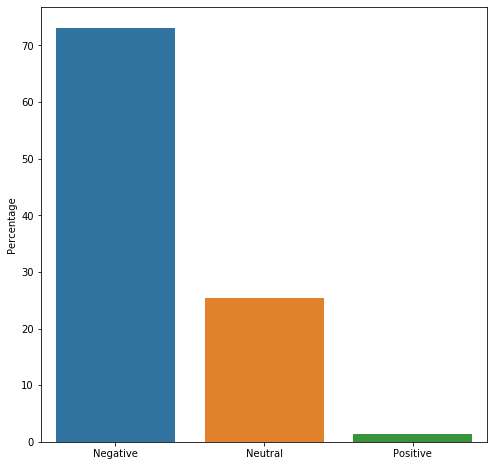

In [295]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))
sns.color_palette("rocket_r")
counts = sentiment_df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

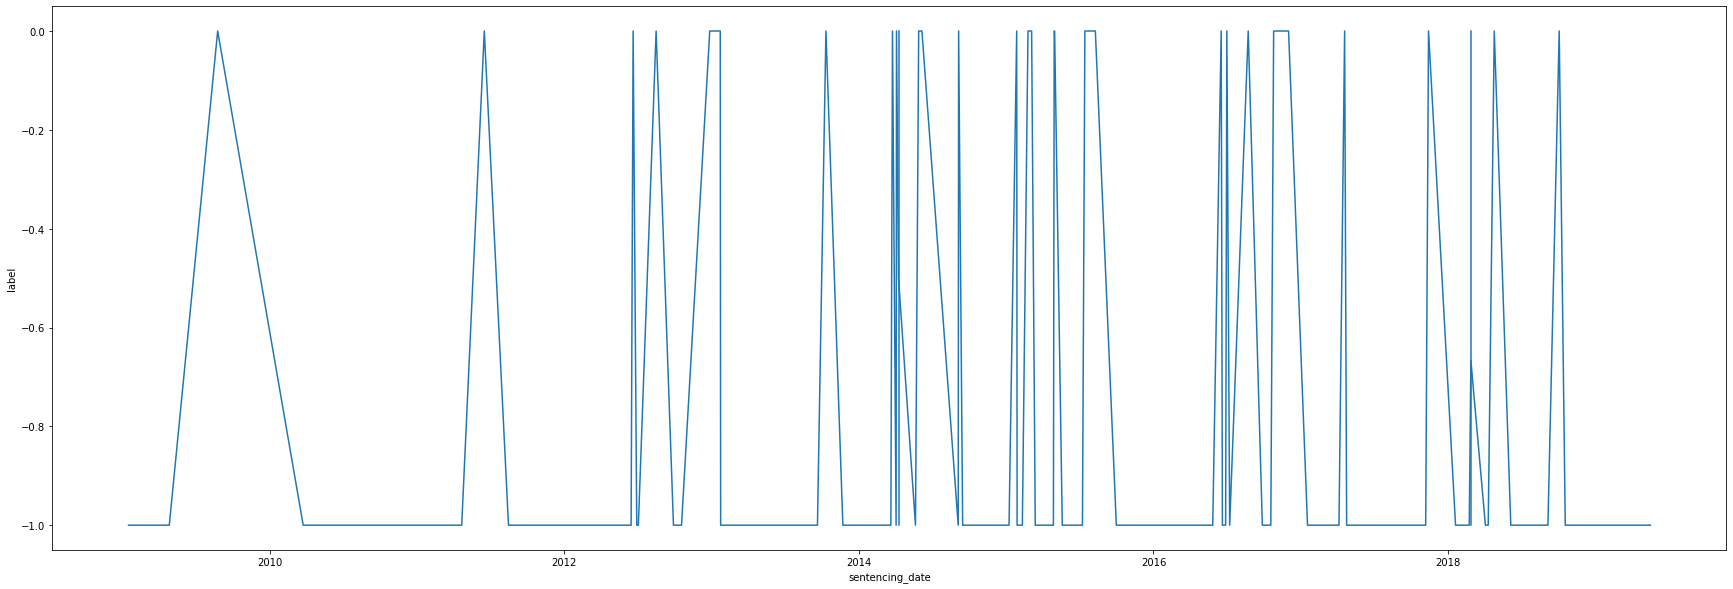

In [303]:
from matplotlib import rcParams
sns.lineplot(x="sentencing_date", y="label", data=sentiment_df, err_style='bars') 
rcParams['figure.figsize'] = 30,10
rcParams['font.size'] = 20
plt.show()
